# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import pytz
import datetime 
import astral
import astropy.time as aptime
import os

file paths & save paths

In [2]:
data_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/datatables/'

In [93]:
save_path = '/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Preliminary/'

In [3]:
txt_file1 = pd.read_csv(data_path + 'IFS_RawContrast_Gemini_env_20180530_all_seeing.csv')
txt_file1_copy = copy.copy(txt_file1)
raw_contrast_data= pd.DataFrame(txt_file1_copy)
print len(raw_contrast_data)

raw_contrast_data['dts'] = aptime.Time(raw_contrast_data['MJDOBS'], format='mjd').datetime 
raw_contrast_data['dts'] = raw_contrast_data['dts'].dt.tz_localize(pytz.UTC)

24155


In [ ]:
txt_file2 = pd.read_csv(data_path + 'sp_psd_summary20181126.csv',index_col=0)
txt_file2_copy = copy.copy(txt_file2)
sp_psd_data = pd.DataFrame(txt_file2_copy)

In [97]:
sp_psd_data['dts'] = pd.to_datetime(sp_psd_data.loc[:,'filename'].str.split('_').str.get(2) + '_' + sp_psd_data.loc[:,'filename'].str.split('_').str.get(3),
              utc=True, format = '%Y.%m.%d_%H.%M.%S')

sp_psd_data['dts'] = sp_psd_data['dts'].dt.tz_localize(pytz.UTC)
sp_psd_data['whenstr'] = sp_psd_data['whenstr'].astype('str')

Merge PSD data with IFS data

In [6]:
def filter_data(data, imag = 10., tau = 1., see = 2., all_cond = True):
    "This selects all rows of input dataframe that satisfy conditions set by the user"
    
    date1 = datetime.date(year = 2014, month = 1, day =1)
    
    #  AO system requirements
    cond1 = data['dts'] > date1 
    cond2 = data['COADDS'] == 1
    cond3 = (data['OBSMODE'] == 'H_coron')|(data['OBSMODE'] == 'Spec')
    cond4 = data['AOFRAMES'] == 1000

    #  Good seeing conditions
    cond5 = data['IMAG'] < imag #Bright Stars
    cond6 = data['MASSTAU'] > tau  # slow moving turbulence [ms]
    cond7 = data['DIMMSEE'] < see  # smaller scale turbulence ["]
    
    if all_cond:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7)[0]  
        print len(ind)
    else:
        ind = np.where(cond1 & cond2 & cond3 & cond4 & cond5)[0]  
        print len(ind)

    filtered_data = data.iloc[ind]
    #filtered_data = filtered_data.dropna(subset = ['CONTR040','cal_wfe','M1_avg','TAMBIENT','Outside_OE_temperature'])
    
    new_ind = np.arange(len(filtered_data))
    filtered_data = filtered_data.set_index(new_ind)
        
    return filtered_data

In [101]:
r = filter_data(raw_contrast_data,all_cond=False)

17041


In [102]:
sp_psd_raw_IFS_data =  pd.merge_asof(raw_contrast_data,sp_psd_data[['slope','dts']].sort_values('dts'), on='dts',tolerance=pd.Timedelta('1min'))

In [103]:
print sum(np.isfinite(sp_psd_raw_IFS_data['slope']))

30


<IPython.core.display.Javascript object>


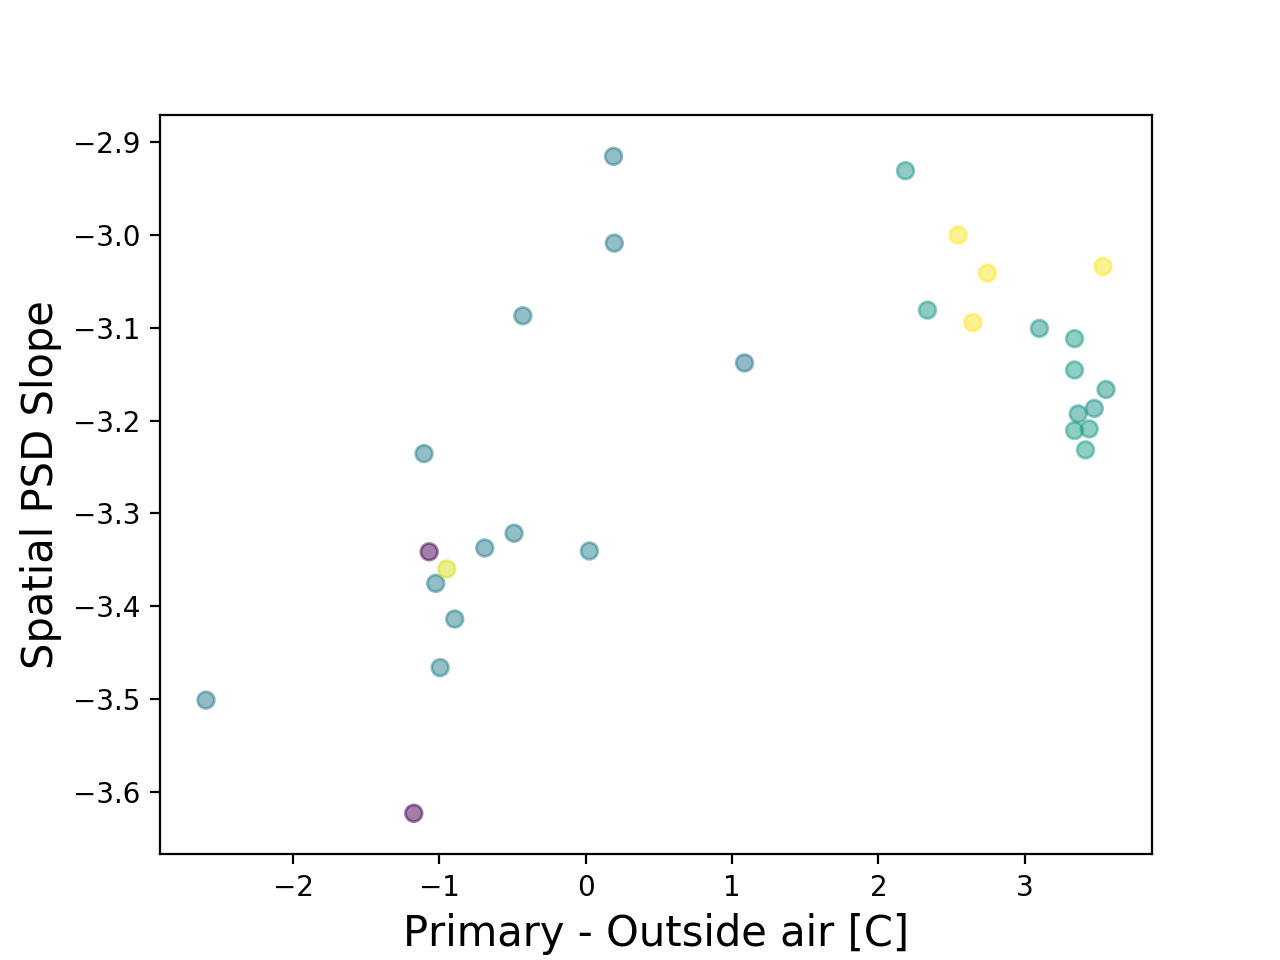

In [104]:
%matplotlib notebook

plt.figure()
plt.scatter(sp_psd_raw_IFS_data['M1_avg']-sp_psd_raw_IFS_data['TAMBIENT'],sp_psd_raw_IFS_data['slope']
            ,c=sp_psd_raw_IFS_data['night_number'],alpha=.5)
plt.ylabel('Spatial PSD Slope',fontsize=15)
plt.xlabel('Primary - Outside air [C]',fontsize=15)
plt.savefig(save_path+'sp_psd_slope_vs_delT_night_20181119.pdf')
#plt.plot(sp_psd_raw_IFS_data['slope'],'.',alpha=.5)

In [81]:
len(pd.unique(sp_psd_raw_IFS_data[['dts','slope','M1_avg','TAMBIENT','night_number']].dropna()['night_number']))

32

In [46]:
sp_psd_raw_IFS_data[['dts','slope','M1_avg','TAMBIENT','night_number']].dropna()

,dts,slope,M1_avg,TAMBIENT,night_number
105,2014-11-09 03:57:24.413760+00:00,-3.661848,12.810,14.2,1.0
414,2014-11-11 00:39:13.155839+00:00,-3.375269,13.570,10.8,3.0
456,2014-11-11 02:45:06.382080+00:00,-3.138347,13.145,10.1,3.0
465,2014-11-11 02:56:42.636480+00:00,-2.940396,13.045,10.0,3.0
1829,2015-01-29 04:25:10.197120+00:00,-3.281668,15.330,13.1,11.0
1969,2015-01-30 02:29:33.478080+00:00,-3.200935,15.915,15.7,12.0
2907,2015-04-06 06:50:06.184320+00:00,-3.567005,13.400,13.6,18.0
4377,2015-07-02 07:27:33.094080+00:00,-3.054863,7.600,4.0,24.0
4386,2015-07-02 07:38:47.938560+00:00,-2.984668,7.580,4.1,24.0
4755,2015-07-03 07:27:41.690880+00:00,-3.078428,6.505,4.7,25.0
